In [7]:
import pandas as pd
import os
import pdfplumber
from transformers import pipeline
import collections
import ollama
import time
import json
import re
# --- Configurações de Pastas ---
# Caminho da pasta raiz
CAMINHO_BASE = r'C:\Users\PC1\Desktop\Processos'

# Caminho onde estão os PDFs filtrados
PASTA_PDFS = os.path.join(CAMINHO_BASE, 'Processos Filtrados')

# Caminho do arquivo CSV
# Ajuste o nome do arquivo aqui se necessário
ARQUIVO_CSV = os.path.join(CAMINHO_BASE, 'amostra_processos_final.csv')

print("Bibliotecas importadas e caminhos definidos.")
print(f"Buscando CSV em: {ARQUIVO_CSV}")
print(f"Buscando PDFs em: {PASTA_PDFS}")

In [8]:
try:
    # Carrega o CSV
    df = pd.read_csv(ARQUIVO_CSV)
    
    # Mostra as informações básicas
    print(f"✅ Sucesso! O DataFrame foi carregado com {len(df)} linhas.")
    
    # Mostra as 3 primeiras linhas para você conferir as colunas
    display(df.head(3)) # 'display' deixa a tabela bonita no notebook
    
except FileNotFoundError:
    print("❌ Erro: Arquivo CSV não encontrado.")
    print("Verifique se o nome do arquivo é 'amostra_processos_final.csv' ou 'amostra_procesos_final.csv'")

In [3]:
# 1. Renomeando as colunas conforme solicitado
# Dicionário: { 'Nome_Antigo': 'Nome_Novo' }
df = df.rename(columns={
    'NUP_Formatado': 'N_Processo',
    'Target': 'Cat_Decisao',
    'Genero': 'Cat_Genero'
})

# 2. Removendo a coluna do magistrado (Magistrado_Scraping)
# O parâmetro 'errors="ignore"' evita travar o código se a coluna já tiver sido apagada antes
df = df.drop(columns=['Magistrado_Scraping'], errors='ignore')

# 3. Conferência visual
print("✅ Colunas ajustadas com sucesso!")
print("Novas colunas:", df.columns.tolist())
display(df.head(3))

✅ Colunas ajustadas com sucesso!
Novas colunas: ['N_Processo', 'Decisao', 'Cat_Decisao', 'Cat_Genero']


,N_Processo,Decisao,Cat_Decisao,Cat_Genero
0,0701079-51.2021.8.02.0051,Procedência em Parte,1,1
1,0724095-87.2021.8.02.0001,Procedência em Parte,1,0
2,0709177-04.2021.8.02.0058,Procedência em Parte,1,1


In [4]:
# Célula 3: Carregamento do Modelo (Versão Robusta para Português)
print("Iniciando carregamento do modelo de Sentimento em Português...")

# Vamos usar o modelo oficial da biblioteca PySentimiento
# Ele retorna: 'POS' (Positivo), 'NEG' (Negativo), 'NEU' (Neutro)
analisador_sentimento = pipeline(
    "sentiment-analysis", 
    model="pysentimiento/robertuito-sentiment-analysis"
)

print("✅ Modelo carregado com sucesso!")

Iniciando carregamento do modelo de Sentimento em Português...


Device set to use cpu


✅ Modelo carregado com sucesso!


In [14]:
import pandas as pd
import time

# ================= CONFIGURAÇÃO DE EXECUÇÃO TOTAL =================
ARQUIVO_SAIDA = os.path.join(CAMINHO_BASE, 'resultado_sentimentos_final.csv')
SALVAR_A_CADA = 10  # Salva o arquivo a cada 10 processos processados

print(f"🚀 Iniciando processamento TOTAL de {len(df)} processos...")
print(f"💾 Os resultados serão salvos gradualmente em: {ARQUIVO_SAIDA}")

# Lista para guardar os resultados na memória RAM
resultados_buffer = []

# Variável para contar o tempo total
inicio_total = time.time()

# Itera sobre TODO o dataframe (sem o .head)
# Usamos enumerate para ter um contador visual (1/1000, 2/1000...)
for i, (index, row) in enumerate(df.iterrows()):
    nup = row['N_Processo']
    
    # Barra de progresso visual no print
    print(f"\n[{i+1}/{len(df)}] Processando NUP: {nup}...", end="")
    
    # 1. Extrai Texto
    texto = extrair_texto_completo(nup)
    
    if texto:
        # 2. Consulta LLM
        analise = consultar_llm_sentimento(texto)
        print(f" -> {analise.get('sentimento')}") # Mostra só o veredito pra não poluir
        
        # Adiciona ao buffer
        resultados_buffer.append({
            "N_Processo": nup,
            "Sentimento_IA": analise.get('sentimento'),
            "Tom_IA": analise.get('tom'),
            "Trecho_Chave": analise.get('trecho_chave'),
            "Texto_Processado": True # Marca que deu certo
        })
    else:
        print(" -> ❌ PDF NÃO ENCONTRADO/VAZIO")
        resultados_buffer.append({
            "N_Processo": nup,
            "Sentimento_IA": "ERRO_LEITURA",
            "Tom_IA": "PDF Vazio",
            "Trecho_Chave": "",
            "Texto_Processado": False
        })
    
    # --- CHECKPOINT DE SEGURANÇA ---
    # A cada X processos, salva tudo o que já foi feito no disco
    if (i + 1) % SALVAR_A_CADA == 0:
        df_parcial = pd.DataFrame(resultados_buffer)
        df_parcial.to_csv(ARQUIVO_SAIDA, index=False, encoding='utf-8-sig', sep=';')
        print(f"   💾 Checkpoint: {len(df_parcial)} resultados salvos no disco.")

# ================= SALVAMENTO FINAL =================
# Garante que o restante seja salvo no final
df_final = pd.DataFrame(resultados_buffer)
df_final.to_csv(ARQUIVO_SAIDA, index=False, encoding='utf-8-sig', sep=';')

tempo_total = (time.time() - inicio_total) / 60
print("\n" + "="*50)
print(f"✅ CONCLUÍDO! Tempo total: {tempo_total:.2f} minutos.")
print(f"Arquivo final salvo em: {ARQUIVO_SAIDA}")
display(df_final.head())

🚀 Iniciando processamento TOTAL de 500 processos...
💾 Os resultados serão salvos gradualmente em: C:\Users\PC1\Desktop\Processos\resultado_sentimentos_final.csv

[1/500] Processando NUP: 0701079-51.2021.8.02.0051...
--- [DEBUG] Iniciando Análise de Nova Sentença ---
   [DEBUG] Tamanho do texto limpo: 3033 caracteres
   [DEBUG] ⏳ Enviando para o Ollama (aguarde, pode demorar 10-30s)...
   [DEBUG] 📩 Resposta Bruta do Modelo: {
  "classificacao": "RIGIDO",
  "justificativa_curta": "O tom do juiz é firme e autoritário, sem muitas explicações ou justificativas adicionais, o que caracteriza um tom rigido e critico"
}
   [DEBUG] ✅ JSON decodificado com sucesso: {'classificacao': 'RIGIDO', 'justificativa_curta': 'O tom do juiz é firme e autoritário, sem muitas explicações ou justificativas adicionais, o que caracteriza um tom rigido e critico'}
 -> RIGIDO

[2/500] Processando NUP: 0724095-87.2021.8.02.0001...
--- [DEBUG] Iniciando Análise de Nova Sentença ---
   [DEBUG] Tamanho do texto limpo:

,N_Processo,Sentimento_IA,Tom_IA,Trecho_Chave,Texto_Processado
0,0701079-51.2021.8.02.0051,RIGIDO,"O tom do juiz é firme e autoritário, sem muita...",Processado via Llama,True
1,0724095-87.2021.8.02.0001,EMPATICO,O juiz demonstra empatia com a situação do aut...,Processado via Llama,True
2,0709177-04.2021.8.02.0058,RIGIDO,"O tom é formal e autoritário, sem expressão de...",Processado via Llama,True
3,0723311-13.2021.8.02.0001,EMPATICO,"O juiz demonstra empatia pela vítima, reconhec...",Processado via Llama,True
4,0710238-71.2021.8.02.0001,RIGIDO,"O juiz utiliza um tom formal e autoritário, se...",Processado via Llama,True


In [15]:
# ================= CONSOLIDAÇÃO DOS DADOS =================

print("Iniciando o cruzamento dos dados originais com a análise da IA...")

# 1. Verifica se os DataFrames estão na memória
# Se por acaso você fechou o notebook, descomente as linhas abaixo para carregar do disco:
# df = pd.read_csv(ARQUIVO_CSV) # Seu arquivo original
# df = df.rename(columns={'NUP_Formatado': 'N_Processo', 'Target': 'Cat_Decisao', 'Genero': 'Cat_Genero'})
# df_final = pd.read_csv(ARQUIVO_SAIDA, sep=';') # O resultado da IA salvo no disco

# 2. Realiza o MERGE (Cruzamento)
# Usamos 'how="left"' para garantir que mantemos todos os processos originais,
# mesmo que algum não tenha sido processado pela IA (o que geraria nulos, mas não perde linhas).
df_completo = pd.merge(
    left=df,               # Tabela da Esquerda (Dados Originais: Gênero, Decisão)
    right=df_final,        # Tabela da Direita (Dados da IA: Sentimento, Tom)
    on='N_Processo',       # A chave única que liga as duas tabelas
    how='left'
)

# 3. Conferência Rápida
print(f"\n✅ Fusão concluída!")
print(f"Linhas no original: {len(df)}")
print(f"Linhas no final: {len(df_completo)}")

# Mostra colunas para você ver que juntou tudo
print("\nColunas do novo arquivo:")
print(df_completo.columns.tolist())

# 4. Salva o Arquivo "Ouro" (Definitivo)
NOME_ARQUIVO_FINAL = os.path.join(CAMINHO_BASE, 'base_juridica_consolidada_IA.csv')

df_completo.to_csv(
    NOME_ARQUIVO_FINAL, 
    index=False, 
    sep=';', 
    encoding='utf-8-sig' # Importante para acentos (ç, ã) no Excel
)

print(f"\n💾 Arquivo COMPLETO salvo em: {NOME_ARQUIVO_FINAL}")

# 5. Visualização final
display(df_completo.head())

Iniciando o cruzamento dos dados originais com a análise da IA...

✅ Fusão concluída!
Linhas no original: 500
Linhas no final: 500

Colunas do novo arquivo:
['N_Processo', 'Decisao', 'Cat_Decisao', 'Cat_Genero', 'Sentimento_IA', 'Tom_IA', 'Trecho_Chave', 'Texto_Processado']

💾 Arquivo COMPLETO salvo em: C:\Users\PC1\Desktop\Processos\base_juridica_consolidada_IA.csv


,N_Processo,Decisao,Cat_Decisao,Cat_Genero,Sentimento_IA,Tom_IA,Trecho_Chave,Texto_Processado
0,0701079-51.2021.8.02.0051,Procedência em Parte,1,1,RIGIDO,"O tom do juiz é firme e autoritário, sem muita...",Processado via Llama,True
1,0724095-87.2021.8.02.0001,Procedência em Parte,1,0,EMPATICO,O juiz demonstra empatia com a situação do aut...,Processado via Llama,True
2,0709177-04.2021.8.02.0058,Procedência em Parte,1,1,RIGIDO,"O tom é formal e autoritário, sem expressão de...",Processado via Llama,True
3,0723311-13.2021.8.02.0001,Procedência em Parte,1,0,EMPATICO,"O juiz demonstra empatia pela vítima, reconhec...",Processado via Llama,True
4,0710238-71.2021.8.02.0001,Procedência em Parte,1,0,RIGIDO,"O juiz utiliza um tom formal e autoritário, se...",Processado via Llama,True


In [21]:
import pandas as pd
import os
import pdfplumber
import ollama
import time
import json
import re

# ================= CONFIGURAÇÕES INICIAIS =================
CAMINHO_BASE = r'C:\Users\PC1\Desktop\Processos'
PASTA_PDFS = os.path.join(CAMINHO_BASE, 'Processos Filtrados')
ARQUIVO_CSV = os.path.join(CAMINHO_BASE, 'amostra_processos_final.csv')
ARQUIVO_SAIDA_V2 = os.path.join(CAMINHO_BASE, 'resultado_sentimentos_v2_com_confianca.csv')
MODELO_LLM = "llama3.2" 
SALVAR_A_CADA = 10

# Carrega o DF original
try:
    df = pd.read_csv(ARQUIVO_CSV)
    # Garante renomeação (caso o arquivo original ainda não tenha sido salvo renomeado)
    df = df.rename(columns={'NUP_Formatado': 'N_Processo', 'Target': 'Cat_Decisao', 'Genero': 'Cat_Genero'})
    print(f"✅ DataFrame carregado: {len(df)} processos na fila.")
except Exception as e:
    print(f"❌ Erro ao abrir CSV: {e}")

# ================= 1. FUNÇÃO DE EXTRAÇÃO DE PDF =================
def extrair_texto_completo(nup):
    nome_arquivo = f"{nup}.pdf"
    caminho_completo = os.path.join(PASTA_PDFS, nome_arquivo)
    
    if not os.path.exists(caminho_completo):
        # Tenta sem pontuação
        nup_limpo = re.sub(r'[^0-9]', '', str(nup)) 
        caminho_alternativo = os.path.join(PASTA_PDFS, f"{nup_limpo}.pdf")
        if os.path.exists(caminho_alternativo):
            caminho_completo = caminho_alternativo
        else:
            return "" # Arquivo não achado

    texto_extraido = ""
    try:
        with pdfplumber.open(caminho_completo) as pdf:
            for page in pdf.pages:
                t = page.extract_text()
                if t: texto_extraido += t + "\n"
        return texto_extraido
    except:
        return ""

# ================= 2. FUNÇÃO DE LIMPEZA =================
def limpar_texto_juridico(texto):
    if not texto: return ""
    padroes_lixo = [r"PODER JUDICIARIO", r"DE ALAGOAS", r"Juízo de Direito", r"assinado digitalmente", r"fls\."]
    linhas = texto.split('\n')
    linhas_limpas = [l for l in linhas if not any(re.search(p, l, re.IGNORECASE) for p in padroes_lixo) and len(l.strip()) > 5]
    return "\n".join(linhas_limpas).replace('{','').replace('}','')

# ================= 3. FUNÇÃO LLM (COM CONFIANÇA) =================
def consultar_llm_sentimento(texto_decisao):
    texto_tratado = limpar_texto_juridico(texto_decisao)
    
    # Corte Estratégico (Início + Fim)
    if len(texto_tratado) > 6000:
        texto_final = texto_tratado[:2000] + "\n...[CORTE]...\n" + texto_tratado[-4000:]
    else:
        texto_final = texto_tratado

    # --- PROMPT ATUALIZADO ---
    prompt_sistema = """
    Você é um linguista forense. Analise o TOM do juiz.
    
    CLASSIFICAÇÕES (Escolha uma):
    1. RIGIDO (Duro, critica má-fé, sermão, termos como 'aventura jurídica')
    2. EMPATICO (Sensível, cita dignidade, protege vulnerável, lamenta danos)
    3. TECNICO (Frio, burocrático, apenas lei, 'copia e cola')
    
    NIVEL DE CONFIANÇA:
    - ALTA: O texto tem adjetivos claros.
    - MEDIA: O texto é padrão mas tem viés perceptível.
    - BAIXA: Texto ambíguo, cortado ou genérico demais.

    Retorne APENAS JSON:
    {
        "classificacao": "RIGIDO" ou "EMPATICO" ou "TECNICO",
        "confianca": "ALTA" ou "MEDIA" ou "BAIXA",
        "justificativa": "resumo curto do motivo"
    }
    """
    
    try:
        resposta = ollama.chat(
            model=MODELO_LLM, 
            format='json',
            options={'temperature': 0.1}, 
            messages=[
                {'role': 'system', 'content': prompt_sistema},
                {'role': 'user', 'content': f"TEXTO:\n{texto_final}"} 
            ]
        )
        
        conteudo = resposta['message']['content']
        match = re.search(r'\{.*\}', conteudo, re.DOTALL)
        
        if match:
            dados = json.loads(match.group(0))
            return {
                "sentimento": dados.get("classificacao", "NEUTRO").upper(),
                "confianca": dados.get("confianca", "BAIXA").upper(), # Nova métrica
                "tom": dados.get("justificativa", "Sem justificativa"),
                "trecho_chave": "Processado v2" 
            }
        else:
            return {"sentimento": "ERRO_FORMATO", "confianca": "N/A", "tom": "JSON Falhou", "trecho_chave": ""}

    except Exception as e:
        return {"sentimento": "ERRO_SISTEMA", "confianca": "N/A", "tom": str(e), "trecho_chave": ""}

# ================= 4. EXECUÇÃO TOTAL =================
print(f"🚀 Iniciando Análise Completa V2 em {len(df)} processos...")
print(f"💾 Salvando em: {ARQUIVO_SAIDA_V2}")

resultados_buffer = []
inicio_total = time.time()

for i, (index, row) in enumerate(df.iterrows()):
    nup = row['N_Processo']
    print(f"\r[{i+1}/{len(df)}] Processando {nup}...", end="") # \r faz o print ficar na mesma linha
    
    texto = extrair_texto_completo(nup)
    
    if texto:
        analise = consultar_llm_sentimento(texto)
        resultados_buffer.append({
            "N_Processo": nup,
            "Sentimento_IA": analise.get('sentimento'),
            "Confianca_IA": analise.get('confianca'), # <--- NOVA COLUNA
            "Tom_IA": analise.get('tom'),
            "Texto_Processado": True
        })
    else:
        resultados_buffer.append({
            "N_Processo": nup,
            "Sentimento_IA": "ARQUIVO_ERRO",
            "Confianca_IA": "N/A",
            "Tom_IA": "PDF Vazio/Não achado",
            "Texto_Processado": False
        })
    
    # Checkpoint
    if (i + 1) % SALVAR_A_CADA == 0:
        pd.DataFrame(resultados_buffer).to_csv(ARQUIVO_SAIDA_V2, index=False, sep=';', encoding='utf-8-sig')

# Salvamento Final
df_final_v2 = pd.DataFrame(resultados_buffer)
df_final_v2.to_csv(ARQUIVO_SAIDA_V2, index=False, sep=';', encoding='utf-8-sig')

tempo = (time.time() - inicio_total) / 60
print(f"\n\n✅ CONCLUÍDO V2! Tempo: {tempo:.2f} min.")
display(df_final_v2.head())

✅ DataFrame carregado: 500 processos na fila.
🚀 Iniciando Análise Completa V2 em 500 processos...
💾 Salvando em: C:\Users\PC1\Desktop\Processos\resultado_sentimentos_v2_com_confianca.csv
[500/500] Processando 0725791-61.2021.8.02.0001...

✅ CONCLUÍDO V2! Tempo: 69.22 min.


,N_Processo,Sentimento_IA,Confianca_IA,Tom_IA,Texto_Processado
0,0701079-51.2021.8.02.0051,RIGIDO,ALTA,O texto apresenta uma linguagem formal e estru...,True
1,0724095-87.2021.8.02.0001,EMPATICO,ALTA,O juiz demonstra empatia com a situação do aut...,True
2,0709177-04.2021.8.02.0058,RIGIDO,ALTA,O texto apresenta uma linguagem formal e estru...,True
3,0723311-13.2021.8.02.0001,EMPATICO,ALTA,"O juiz demonstra empatia pela vítima, reconhec...",True
4,0710238-71.2021.8.02.0001,RIGIDO,ALTA,O texto apresenta uma linguagem formal e técni...,True


In [25]:
# ================= AUDITORIA HUMANA DETALHADA =================

# Configuração: Quantos processos de cada tipo você quer ler?
QTD_AMOSTRA = 5 

def exibir_amostra_detalhada(df, sentimento_alvo):
    print(f"\n{'='*20} AUDITANDO: {sentimento_alvo} {'='*20}")
    
    # Filtra apenas o sentimento desejado
    df_filtro = df[df['Sentimento_IA'] == sentimento_alvo]
    
    # Verifica se existem registros suficientes
    if len(df_filtro) == 0:
        print(" [!] Nenhum processo encontrado com essa classificação.")
        return
    
    # Pega uma amostra aleatória (ou todos se tiver menos que a quantidade pedida)
    n_amostra = min(QTD_AMOSTRA, len(df_filtro))
    amostra = df_filtro.sample(n=n_amostra)
    
    for i, row in amostra.iterrows():
        print(f"\n📄 Processo: {row['N_Processo']}")
        print(f"   🤖 Classificação: {row['Sentimento_IA']}")
        print(f"   💬 Justificativa da IA (Tom): \"{row['Tom_IA']}\"")
        print(f"   🔑 Palavras-Chave Detectadas: \"{row['Trecho_Chave']}\"")
        print("-" * 60)

# --- EXECUÇÃO DA AUDITORIA ---

# 1. Auditar os RÍGIDOS (Onde geralmente mora a polêmica)
exibir_amostra_detalhada(df_completo, 'RIGIDO')

# 2. Auditar os EMPÁTICOS (Para ver se ela não está confundindo educação com empatia)
exibir_amostra_detalhada(df_completo, 'EMPATICO')

# 3. Auditar os TÉCNICOS (Para ver se ela não está sendo 'preguiçosa')
exibir_amostra_detalhada(df_completo, 'TECNICO')


==================== AUDITANDO: RIGIDO ====================

📄 Processo: 0700851-82.2021.8.02.0049
   🤖 Classificação: RIGIDO
   💬 Justificativa da IA (Tom): "O tom do juiz é formal e autoritário, sem muitas expressões emocionais ou sensíveis, apenas focado em transmitir a decisão final de forma clara e objetiva."
   🔑 Palavras-Chave Detectadas: "Processado via Llama"
------------------------------------------------------------

📄 Processo: 0700416-62.2021.8.02.0032
   🤖 Classificação: RIGIDO
   💬 Justificativa da IA (Tom): "O juiz utiliza um tom formal e autoritário, sem mostrar empatia ou compreensão pelas razões da parte autora. Além disso, o texto apresenta uma linguagem jurídica técnica e complexa, o que sugere uma abordagem rigorosa e menos empática."
   🔑 Palavras-Chave Detectadas: "Processado via Llama"
------------------------------------------------------------

📄 Processo: 0723439-33.2021.8.02.0001
   🤖 Classificação: RIGIDO
   💬 Justificativa da IA (Tom): "O tom do juiz é 

In [26]:
# ================= CONSOLIDAÇÃO FINAL V2 =================

print("Unificando dados originais com a Análise V2 (Com Confiança)...")

# 1. Carrega o original (caso não esteja na memória)
# df = pd.read_csv(ARQUIVO_CSV) 
# df = df.rename(columns={'NUP_Formatado': 'N_Processo', 'Target': 'Cat_Decisao', 'Genero': 'Cat_Genero'})

# 2. Realiza o MERGE
df_completo_v2 = pd.merge(
    left=df,               # Dados originais
    right=df_final_v2,     # Dados da IA V2
    on='N_Processo',
    how='left'
)

# 3. Salva o Arquivo FINALÍSSIMO
NOME_ARQUIVO_FINAL_V2 = os.path.join(CAMINHO_BASE, 'base_juridica_consolidada_V2_confianca.csv')

df_completo_v2.to_csv(
    NOME_ARQUIVO_FINAL_V2, 
    index=False, 
    sep=';', 
    encoding='utf-8-sig'
)

print(f"\n💾 Arquivo salvo com sucesso: {NOME_ARQUIVO_FINAL_V2}")
display(df_completo_v2.head())

Unificando dados originais com a Análise V2 (Com Confiança)...

💾 Arquivo salvo com sucesso: C:\Users\PC1\Desktop\Processos\base_juridica_consolidada_V2_confianca.csv


,N_Processo,Decisao,Magistrado_Scraping,Cat_Decisao,Cat_Genero,Sentimento_IA,Confianca_IA,Tom_IA,Texto_Processado
0,0701079-51.2021.8.02.0051,Procedência em Parte,Larrissa Gabriella Lins Victor Lacerda,1,1,RIGIDO,ALTA,O texto apresenta uma linguagem formal e estru...,True
1,0724095-87.2021.8.02.0001,Procedência em Parte,Henrique Gomes de Barros Teixeira,1,0,EMPATICO,ALTA,O juiz demonstra empatia com a situação do aut...,True
2,0709177-04.2021.8.02.0058,Procedência em Parte,Luciana Josué Raposo Lima Dias,1,1,RIGIDO,ALTA,O texto apresenta uma linguagem formal e estru...,True
3,0723311-13.2021.8.02.0001,Procedência em Parte,Sérgio Wanderley Persiano,1,0,EMPATICO,ALTA,"O juiz demonstra empatia pela vítima, reconhec...",True
4,0710238-71.2021.8.02.0001,Procedência em Parte,Maurício César Breda Filho,1,0,RIGIDO,ALTA,O texto apresenta uma linguagem formal e técni...,True


=== NÍVEL DE SEGURANÇA DO MODELO (TOTAL) ===


,Qtd,Porcentagem (%)
Confianca_IA,,
ALTA,474,94.80
BAIXA,26,5.20


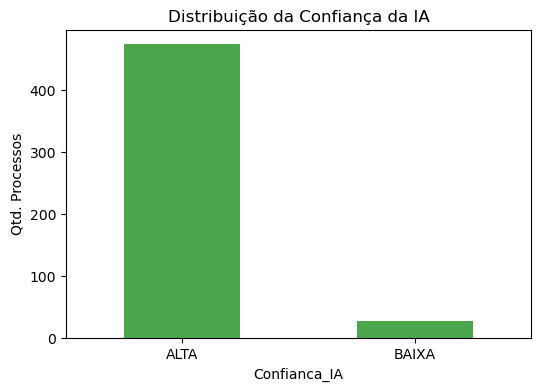

In [32]:
import matplotlib.pyplot as plt

# 1. Tabela de Frequência da Confiança
print("=== NÍVEL DE SEGURANÇA DO MODELO (TOTAL) ===")
contagem_confianca = df_final_v2['Confianca_IA'].value_counts()
porcentagem_confianca = df_final_v2['Confianca_IA'].value_counts(normalize=True) * 100

resumo_confianca = pd.DataFrame({
    'Qtd': contagem_confianca,
    'Porcentagem (%)': porcentagem_confianca
})

pd.options.display.float_format = '{:.2f}'.format
display(resumo_confianca)

# 2. Gráfico rápido
plt.figure(figsize=(6, 4))
contagem_confianca.plot(kind='bar', color='green', alpha=0.7)
plt.title('Distribuição da Confiança da IA')
plt.ylabel('Qtd. Processos')
plt.xticks(rotation=0)
plt.show()

=== ANÁLISE DE SENTIMENTO POR GÊNERO ===

--- Quantidade de Processos ---


Sentimento_IA,EMPATICO,RIGIDO,TECNICO,Total
Cat_Genero,,,,
Feminino,33,124,26,183
Masculino,75,214,28,317
Total,108,338,54,500



--- Distribuição Percentual (%) ---


Sentimento_IA,EMPATICO,RIGIDO,TECNICO
Cat_Genero,,,
Feminino,18.0%,67.8%,14.2%
Masculino,23.7%,67.5%,8.8%


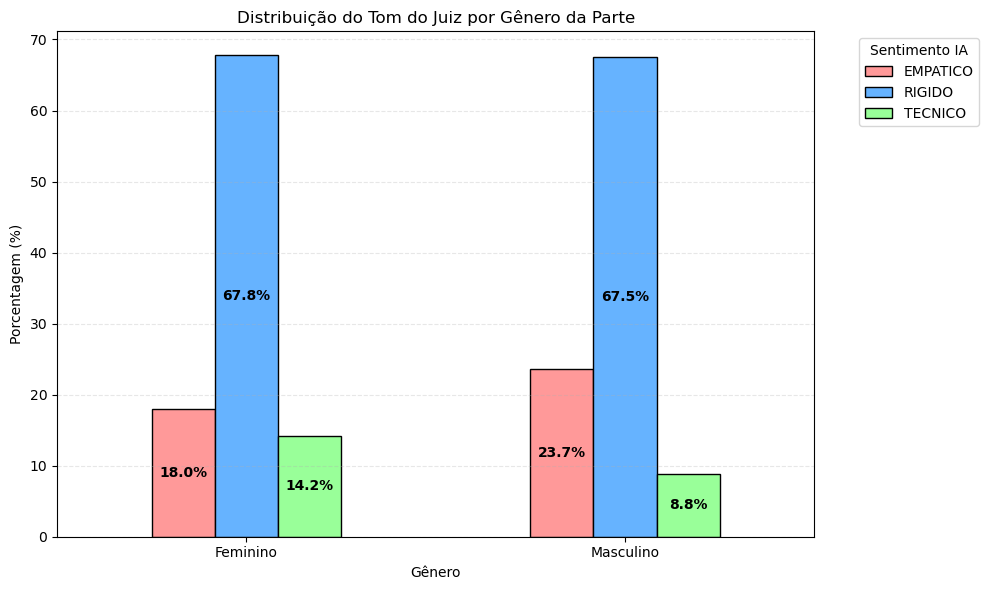

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume que df_completo já existe
# Se precisar recarregar, descomente:
# df_completo = pd.read_csv(os.path.join(CAMINHO_BASE, 'base_juridica_consolidada_IA.csv'), sep=';')

print("=== ANÁLISE DE SENTIMENTO POR GÊNERO ===")

# Dicionário de Mapeamento (Apenas para visualização)
# Isso transforma 0 em Masculino e 1 em Feminino nas tabelas
mapa_visual = {0: 'Masculino', 1: 'Feminino'}

# 1. Tabela de Quantidades Absolutas
tabela_qtd = pd.crosstab(
    index=df_completo['Cat_Genero'].map(mapa_visual), # <--- Mapeamento aplicado aqui
    columns=df_completo['Sentimento_IA'],
    margins=True, 
    margins_name="Total"
)

print("\n--- Quantidade de Processos ---")
display(tabela_qtd)

# 2. Tabela de Porcentagens
tabela_pct = pd.crosstab(
    index=df_completo['Cat_Genero'].map(mapa_visual), # <--- Mapeamento aplicado aqui também
    columns=df_completo['Sentimento_IA'],
    normalize='index' 
) * 100

print("\n--- Distribuição Percentual (%) ---")
pd.options.display.float_format = '{:.1f}%'.format 
display(tabela_pct)

# 3. Gráfico Comparativo
ax = tabela_pct.plot(
    kind='bar', 
    figsize=(10, 6), 
    edgecolor='black',
    rot=0, # Rótulos na horizontal
    color=['#ff9999','#66b3ff','#99ff99'] # (Opcional) Cores para diferenciar melhor
)

plt.title('Distribuição do Tom do Juiz por Gênero da Parte')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Gênero') # Rótulo do eixo X ajustado
plt.legend(title='Sentimento IA', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adiciona os valores nas barras (Ajuste de cor para legibilidade)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', color='black', weight='bold')

plt.tight_layout()
plt.show()

# Retorna formatação padrão
pd.options.display.float_format = None